<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [VAE1] - First VAE, with a small dataset (MNIST)
<!-- DESC --> Construction and training of a VAE with a latent space of small dimension.

<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Understanding and implementing a **variational autoencoder** neurals network (VAE)
 - Understanding a more **advanced programming model**

The calculation needs being important, it is preferable to use a very simple dataset such as MNIST to start with.

## What we're going to do :

 - Defining a VAE model
 - Build the model
 - Train it
 - Follow the learning process with Tensorboard

## Acknowledgements :
Thanks to **François Chollet** who is at the base of this example.  
François Chollet is not only the author of Keras and a great guru, he is also a sorcerer ;-)  
See : https://keras.io/examples/generative/vae


## Step 1 - Init python stuff

In [1]:
import numpy as np
from skimage import io

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import os,sys,json,time,datetime
from IPython.display import display,Image,Markdown,HTML

from modules.VAE          import VAE, Sampling
from modules.loader_MNIST import Loader_MNIST
from modules.callbacks    import ImagesCallback, BestModelCallback

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/MNIST.001'                     # Output directory
datasets_dir = pwk.init('VAE1', run_dir)

VAE.about()

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.20
Notebook id          : VAE1
Run time             : Friday 19 March 2021, 19:58:50
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Datasets dir         : /home/pjluc/datasets/fidle
Run dir              : ./run/MNIST.001
Update keras cache   : False


<br>**FIDLE 2021 - VAE**

Version              : 1.4
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf


## Step 2 - Parameters
Uncomment the right lines according to what you want.

In [2]:
# ---- Smart tests
#
latent_dim    = 2
r_loss_factor = 0.994
scale         = 0.1
batch_size    = 64
epochs        = 10

# ---- Full run (1'30 on a V100)
#
# latent_dim    = 2
# r_loss_factor = 0.994
# scale         = 1.
# batch_size    = 64
# epochs        = 10

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('scale', 'latent_dim', 'r_loss_factor', 'batch_size', 'epochs')

## Step 3 - Prepare data
### 3.1 - Get it

In [4]:
x_train, _ = Loader_MNIST.get()
np.random.shuffle(x_train)
nb_images = int(len(x_train)*scale)
x_train   = x_train[:nb_images]
print('\nTrain shape after rescale : ',x_train.shape)

Dataset loaded.
Normalized.
Expanded.
Concatenate.
x shape : (70000, 28, 28, 1)
y shape : (70000,)

Train shape after rescale :  (7000, 28, 28, 1)


### 3.2 - Have a look

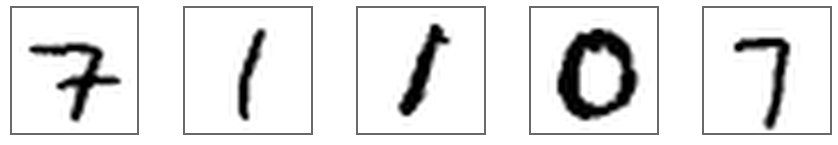

In [5]:
pwk.plot_images(x_train[:5], None, indices='all', columns=5, x_size=3,y_size=2, save_as='01-original')

## Step 4 - Build model

#### Encoder

In [6]:
inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, strides=1, padding="same", activation="relu")(inputs)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=1, padding="same", activation="relu")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z         = Sampling()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.compile()
# encoder.summary()

#### Decoder

In [7]:
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, strides=1, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
outputs = layers.Conv2DTranspose(1,  3, padding="same", activation="sigmoid")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
decoder.compile()
# decoder.summary()

#### VAE
Our loss function is the weighted sum of two values.  
`reconstruction_loss` which measures the loss during reconstruction.  
`kl_loss` which measures the dispersion.  

The weights are defined by: `r_loss_factor` :  
`total_loss = r_loss_factor*reconstruction_loss + (1-r_loss_factor)*kl_loss`

if `r_loss_factor = 1`, the loss function includes only `reconstruction_loss`  
if `r_loss_factor = 0`, the loss function includes only `kl_loss`  
In practice, a value of 0.3 gives good results here.


In [8]:
vae = VAE(encoder, decoder, r_loss_factor)

vae.compile(optimizer=keras.optimizers.Adam())

Init VAE, with r_loss_factor=0.994


## Step 5 - Train
With `scale=1`, need 1'15 on a GPU (V100 at IDRIS) ...or 20' on a CPU  

In [9]:
# ---- Callback : Images encoded
pwk.mkdir(run_dir + '/images-encoded')
filename = run_dir + '/images-encoded/image-{epoch:03d}-{i:02d}.jpg'
callback_images1 = ImagesCallback(filename, x=x_train[:5], encoder=encoder,decoder=decoder)

# ---- Callback : Images generated
pwk.mkdir(run_dir + '/images-generated')
filename = run_dir + '/images-generated/image-{epoch:03d}-{i:02d}.jpg'
callback_images2 = ImagesCallback(filename, x=None, nb_images=5, z_dim=2, encoder=encoder,decoder=decoder)          

# ---- Callback : Best model
pwk.mkdir(run_dir + '/models')
filename = run_dir + '/models/best_model'
callback_bestmodel = BestModelCallback(filename)

# ---- Callback tensorboard
dirname = run_dir + '/logs'
callback_tensorboard = TensorBoard(log_dir=dirname, histogram_freq=1)

# callbacks_list = [callback_images1, callback_images2, callback_bestmodel, callback_tensorboard]
callbacks_list = [callback_images1, callback_images2, callback_bestmodel]

In [10]:
pwk.chrono_start()

history = vae.fit(x_train, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list,)

pwk.chrono_show()

Epoch 1/10
110/110 [==============================] - 6s 53ms/step - loss: 0.3451 - r_loss: 0.3459 - kl_loss: 0.2163
Epoch 2/10
110/110 [==============================] - 6s 59ms/step - loss: 0.2569 - r_loss: 0.2544 - kl_loss: 0.6671
Epoch 3/10
110/110 [==============================] - 6s 53ms/step - loss: 0.2511 - r_loss: 0.2477 - kl_loss: 0.8252
Epoch 4/10
110/110 [==============================] - ETA: 0s - loss: 0.2456 - r_loss: 0.2409 - kl_loss: 1.02 - 6s 50ms/step - loss: 0.2457 - r_loss: 0.2410 - kl_loss: 1.0257
Epoch 5/10
110/110 [==============================] - 6s 53ms/step - loss: 0.2314 - r_loss: 0.2232 - kl_loss: 1.5807
Epoch 6/10
110/110 [==============================] - 6s 54ms/step - loss: 0.2232 - r_loss: 0.2141 - kl_loss: 1.7170
Epoch 7/10
110/110 [==============================] - 6s 54ms/step - loss: 0.2198 - r_loss: 0.2103 - kl_loss: 1.7970
Epoch 8/10
110/110 [==============================] - 6s 54ms/step - loss: 0.2179 - r_loss: 0.2079 - kl_loss: 1.8681
Epoch 

## Step 6 - About our training session
### 6.1 - History

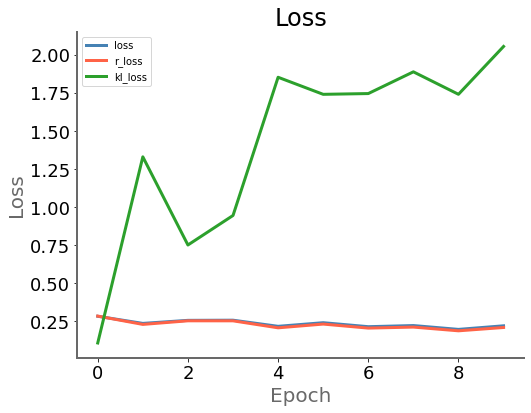

In [11]:
pwk.plot_history(history,  plot={"Loss":['loss','r_loss', 'kl_loss']}, save_as='history')

### 6.2 - Reconstruction (input -> encoder -> decoder)

<br>**Original images :**

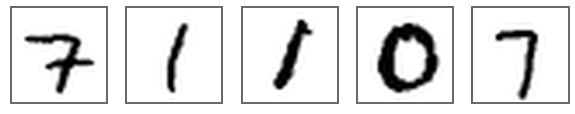

<br>**Encoded/decoded images**

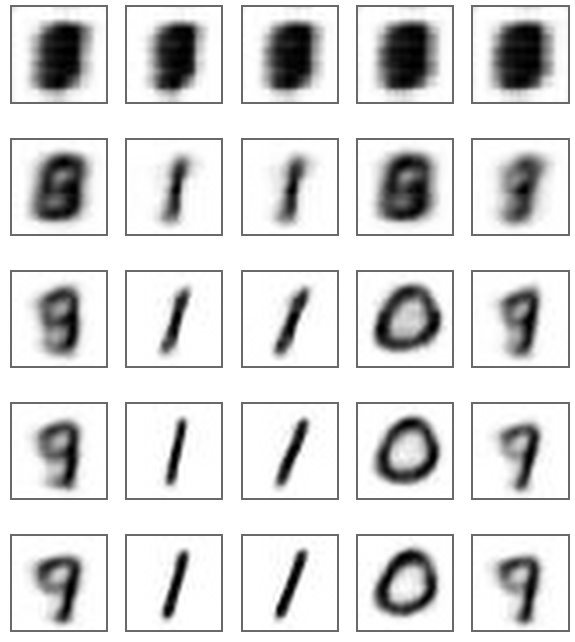

<br>**Original images :**

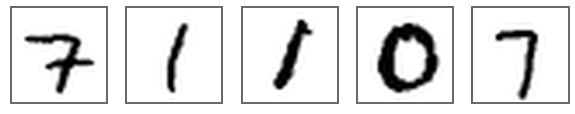

In [12]:
imgs=[]
labels=[]
for epoch in range(0,epochs,2):
    for i in range(5):
        filename = f'{run_dir}/images-encoded/image-{epoch:03d}-{i:02d}.jpg'.format(epoch=epoch, i=i)
        img      = io.imread(filename)
        imgs.append(img)
        

pwk.subtitle('Original images :')
pwk.plot_images(x_train[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as=None)

pwk.subtitle('Encoded/decoded images')
pwk.plot_images(imgs, None, indices='all', columns=5, x_size=2,y_size=2, save_as='02-reconstruct')

pwk.subtitle('Original images :')
pwk.plot_images(x_train[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as=None)


### 6.3 - Generation (latent -> decoder)

<br>**Generated images from latent space**

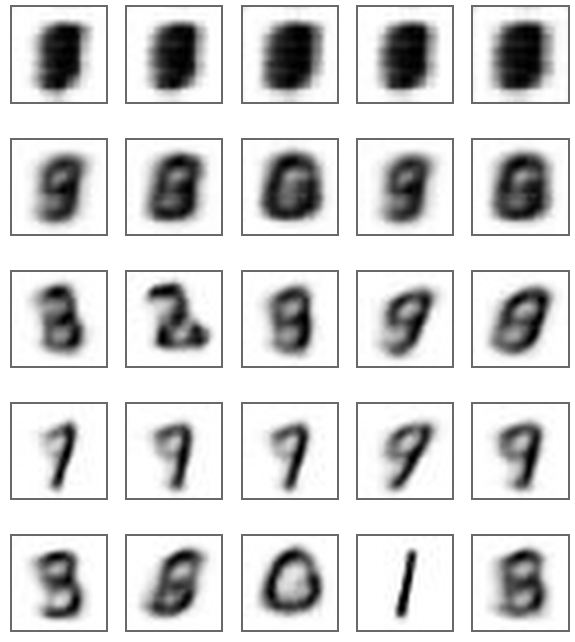

In [13]:
imgs=[]
labels=[]
for epoch in range(0,epochs,2):
    for i in range(5):
        filename = f'{run_dir}/images-generated/image-{epoch:03d}-{i:02d}.jpg'.format(epoch=epoch, i=i)
        img      = io.imread(filename)
        imgs.append(img)
        
pwk.subtitle('Generated images from latent space')
pwk.plot_images(imgs, None, indices='all', columns=5, x_size=2,y_size=2, save_as='03-encoded')


In [14]:
pwk.end()

End time is : Friday 19 March 2021, 19:59:54
Duration is : 00:01:03 452ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>